In [ ]:
# Tiny dataset
# !gdown https://drive.google.com/uc?id=1qYPCnXXxjEcHEg3tLGt3fDkd2ialAgS4
import os
# Full dataset with jpeg
!gdown https://drive.google.com/uc?id=1-xJoBvzwQKgJjPzHb3fq1sFicwyIisx7

# Full dataset without jpeg
# https://drive.google.com/file/d/1gFSdm8K9SXNPXG9tQWS4bmO_nappN2AL/view?usp=share_link
# !gdown https://drive.google.com/uc?id=1gFSdm8K9SXNPXG9tQWS4bmO_nappN2AL
!unzip data_v1.zip -d /content/data
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Downloading...
From: https://drive.google.com/uc?id=1-xJoBvzwQKgJjPzHb3fq1sFicwyIisx7
To: /content/data_v1.zip
100% 640M/640M [00:02<00:00, 275MB/s]
Archive:  data_v1.zip
   creating: /content/data/train-images/
  inflating: /content/data/train-images/00000000002.jpg  
  inflating: /content/data/train-images/00000000003.jpg  
  inflating: /content/data/train-images/00000000004.jpg  
  inflating: /content/data/train-images/00000000005.jpg  
  inflating: /content/data/train-images/00000000006.jpg  
  inflating: /content/data/train-images/00000000009.jpg  
  inflating: /content/data/train-images/00000000010.jpg  
  inflating: /content/data/train-images/00000000017.jpg  
  inflating: /content/data/train-images/00000000020.jpg  
  inflating: /content/data/train-images/00000000022.jpg  
  inflating: /content/data/train-images/00000000023.jpg  
  inflating: /content/data/train-images/00000000025.jpg  
  inflating: /content/data/train-images/00000000026.jpg  
  inflating: /content/data/train-i

In [ ]:
%cd /content/data 
import json
data = json.load(open("train_data.json", "r"))

/content/data


In [ ]:
data['annotations'][0]

{'id': 0,
 'image_id': 2,
 'caption': 'ba chiếc thuyền đang di chuyển ở trên con sông',
 'segment_caption': 'ba chiếc thuyền đang di_chuyển ở trên con sông'}

# Vocab

In [ ]:
from collections import Counter
import itertools
from itertools import count

class IMCP_Vocab():
  def __init__(self, texts) -> None:
    words = list(itertools.chain(*[text.split(" ") for text in texts]))
    counter = Counter(words)
    self.vocab = {key: i for i, key in zip(count(start = 5), counter.keys())}

    self.special_ids = [0, 1, 2, 3]
    self.max_seq_len = 256
    self.special_tokens = ["<s>", "</s>", "<pad>", "<unk>"]
    for id, token in zip(self.special_ids, self.special_tokens):
      self.vocab[token] = id
    self.vocab = {k: v for k, v in sorted(self.vocab.items(), key=lambda x:x[1])}
    self.id2word = {v: k for k, v in self.vocab.items()}
    
    self.bos_token = "<s>"
    self.eos_token = "</s>"
    self.pad_token = "<pad>"
    self.unk_token = "<unk>"
    
  def get_vocab(self):
    return self.vocab
  
  def batch_decode(self, predictions_ids):
    preds = []
    for seq in predictions_ids:
        preds.append(" ".join([self.id2word[id] for id in seq if id not in [0,1,2,3,4,5]]))
    return preds

# Dataset

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import json
import os

class IMCP_Dataset(Dataset):
  def __init__(self, image_path = "train-images", summary_path = "train_data.json"):
    super().__init__()
    self.data = json.load(open(summary_path, "r"))
    self.image_path = image_path
    self.vocab = IMCP_Vocab(texts = [ann['segment_caption'] for ann in self.data['annotations']])
    self.imgid2imgname = {entry['id']: entry['filename'] for entry in self.data['images']}

  def __len__(self):
    return len(self.data['annotations'])

  def __getitem__(self, index):
    annotation = self.data['annotations'][index]
    image_id = annotation['image_id']
    # images = self.data['images'][index]
    # image_id = images['id']
    image_name = self.imgid2imgname[image_id]
    image = Image.open(os.path.join(self.image_path, image_name)).convert('RGB')
    caption = annotation['segment_caption']
    return image, caption

In [ ]:
class IMCP_Test_Dataset(Dataset):
  def __init__(self, image_path = "public-test-images", summary_path = "test_data.json"):
    super().__init__()
    self.data = json.load(open(summary_path, "r"))
    self.image_path = image_path
    self.imgid2imgname = {entry['id']: entry['filename'] for entry in self.data['images']}

  def __len__(self):
    return len(self.data['images'])

  def __getitem__(self, index):
    entry = self.data['images'][index]
    image_id = entry['id']
    image_name = entry['filename']
    image = Image.open(os.path.join(self.image_path, image_name)).convert('RGB')
    caption = [self.data['annotations'][i]['segment_caption'] for i in range(len(self.data['annotations'])) if self.data['annotations'][i]['image_id'] == image_id]
    return image, caption

In [ ]:
train_dataset = IMCP_Dataset()
test_dataset = IMCP_Test_Dataset()
vocab = train_dataset.vocab

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

# Collator

In [ ]:
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms

class IMCP_Collator:
  def __init__(self, vocab, train = True, model = "resnet101"):
    self.vocab = vocab
    self.bos_id = self.vocab.get_vocab()['<s>']
    self.eos_id = self.vocab.get_vocab()['</s>']
    self.pad_id = self.vocab.get_vocab()['<pad>']
    self.model = model
    self.train = train

  def tokenize_texts(self, captions):
    raw_captions = [caption.split(" ") for caption in captions]
    truncated_captions = [s[:self.vocab.max_seq_len] for s in raw_captions]
    max_len = max([len(c) for c in truncated_captions])

    padded_captions = []
    for c in truncated_captions:
        c = [self.vocab.get_vocab()[word] for word in c]
        seq = [self.bos_id] + c + [self.eos_id] + [self.pad_id] * (max_len - len(c))
        padded_captions.append(seq)

    padded_captions = [torch.Tensor(seq).long() for seq in padded_captions]
    padded_captions = pad_sequence(padded_captions, batch_first=True)
    return padded_captions
  
  def resize_and_stack(self, images):
    if self.model == "resnet101":
      image_tensors = []
      transform = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
      ])
      
      for image in images:
        img_tensor = transform(image)
        image.close()
        image_tensors.append(img_tensor)
        
      stacked = torch.stack(image_tensors)
      return stacked
    else:
      pass

  def __call__(self, batch):
    if self.train:
      images = [example[0] for example in batch]
      captions = [example[1] for example in batch]
      return self.resize_and_stack(images), self.tokenize_texts(captions)
    else:
      images = [example[0] for example in batch]
      captions = [example[1] for example in batch]
      return self.resize_and_stack(images), captions
    

In [ ]:
collator = IMCP_Collator(vocab, train = True, model = "resnet101")
collatorTest = IMCP_Collator(vocab, train = False, model = "resnet101")

# DataLoader

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size = 16, collate_fn = collator)
test_dataloader = DataLoader(test_dataset, batch_size = 16, collate_fn = collatorTest)

In [ ]:
for images, captions in train_dataloader:
  print(images.shape)
  print(captions)
  break

torch.Size([16, 3, 224, 224])
tensor([[ 0,  5,  6,  7,  8,  9, 10, 11, 12, 13,  1,  2,  2],
        [ 0, 14,  5, 12,  7,  8,  9, 11, 12, 13,  1,  2,  2],
        [ 0, 11, 15, 13, 14,  5, 12,  7,  8,  9,  1,  2,  2],
        [ 0,  5, 12,  7,  8,  9, 16, 17, 18, 19, 20,  1,  2],
        [ 0,  5,  6,  7,  8, 21, 11, 17, 12, 13,  1,  2,  2],
        [ 0, 22, 23,  8, 24, 17, 25, 26, 11, 27,  1,  2,  2],
        [ 0, 10, 11, 27, 22, 23, 14, 17, 25, 26,  1,  2,  2],
        [ 0, 22, 23, 24, 17, 25, 28, 10, 11, 27,  1,  2,  2],
        [ 0, 14, 17, 25, 28, 11, 27, 29, 22, 23,  1,  2,  2],
        [ 0, 14, 17, 25, 26, 10, 11, 27, 29, 17, 22, 23,  1],
        [ 0, 22, 23,  8, 30, 31, 32,  6, 33,  1,  2,  2,  2],
        [ 0, 14, 34,  6, 33, 35, 36, 22, 23,  1,  2,  2,  2],
        [ 0, 14, 17, 22, 23, 37, 32,  6, 33,  1,  2,  2,  2],
        [ 0, 32,  6, 33,  8, 38, 39, 29, 22, 23,  1,  2,  2],
        [ 0, 22, 23,  8, 40, 32,  6, 33, 10, 35, 36,  1,  2],
        [ 0, 14, 34, 22,  8, 41, 10, 42,

# Model

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Check if GPU is available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pre-trained RestNet101 model
encoder = models.resnet101(pretrained=True).to(device)

# Remove the last layer of the model
modules = list(encoder.children())[:-1]
encoder = nn.Sequential(*modules)

# Freeze the parameters of the model
for param in encoder.parameters():
    param.requires_grad = False

# Define LSTM decoder
class Decoder(nn.Module):
    def __init__(self, feature_size, embed_size, hidden_size, vocab_size, num_layers):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size + feature_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, features, captions):
        captions = captions[:, :-1]
        embeddings = self.embed(captions)
        features = features.squeeze().unsqueeze(1).repeat(1, embeddings.size(1), 1)
        embeddings = torch.cat((features, embeddings), 2)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs
    
    def generate(self, features, max_length):
        batch_size = features.size(0)        
        input = torch.empty(batch_size, 1, device = device, dtype = torch.long).fill_(collator.bos_id)
        track_complete_example = torch.zeros(batch_size)
        hidden = None
        cell = None
        # Loop through all the time steps
        for t in range(max_length - 1):
            embeddings = self.embed(input)
            features2 = features.squeeze(-1).squeeze(-1).unsqueeze(1).repeat(1, embeddings.size(1), 1)
            embeddings = torch.cat((features2, embeddings), 2)
            if t == 0:
                _, (hidden, cell) = self.lstm(embeddings)
            else:
                _, (hidden, cell) = self.lstm(embeddings, (hidden, cell))

            pred = torch.argmax(self.linear(hidden), axis = -1)
            input = torch.cat([input, pred.permute(1, 0)], dim = 1)
            where_end = torch.where(pred == collator.pad_id)[0]
            track_complete_example[where_end] = 1
            if track_complete_example.eq(1).all():
              print("Early break in generate!")
              break

        return input


# Define hyperparameters
num_epochs = 2
embed_size = 256
feature_size = 2048
hidden_size = 512
vocab_size = len(collator.vocab.get_vocab()) + 5
num_layers = 1
total_step = num_epochs * len(train_dataloader)

# Initialize decoder
decoder = Decoder(feature_size, embed_size, hidden_size, vocab_size, num_layers).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)

# Train the model
# for epoch in range(num_epochs):
#     for i, (images, captions) in enumerate(train_dataloader):
#         # Move data to GPU
#         images = images.to(device)
#         captions = captions.to(device)
        
#         # Forward pass
#         features = encoder(images)
#         outputs = decoder(features, captions)
#         loss = criterion(outputs.permute(0, 2, 1), captions[:, 1:])
        
#         # Backward pass and optimization
#         decoder.zero_grad()
#         encoder.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         # Print loss
#         if i % 100 == 0:
#             print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 211MB/s]


# Inference

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
decoder.load_state_dict(torch.load('/content/drive/MyDrive/Lab/checkpoints/reslstm/decoder.pth'))

<All keys matched successfully>

In [ ]:
my_preds = []
targets = []
decoder.eval()
encoder.eval()
for i, (images, captions) in enumerate(test_dataloader):
    images = images.to(device)
    # Forward pass
    features = encoder(images)
    out = decoder.generate(features, 30)
    preds = out.detach().cpu().numpy()
    my_preds.extend(vocab.batch_decode(preds))
    targets.extend(captions)
    break

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
score = corpus_bleu(targets, my_preds)
print(f"BLEU RESNET LSTM: {score}")

BLEU RESNET LSTM: 0.6881074976065634


In [ ]:
!pip install Rouge
from rouge import Rouge

# Load the generated and ground truth captions
generated_captions = my_preds  # List of generated captions
ground_truth_captions = targets  # List of ground truth captions

scores = []
for i in range(len(generated_captions)):
    score = rouge.compute_score([ground_truth_captions[i]], [generated_captions[i]])
    scores.append(score["rouge-l"]["f"])

# Compute the average ROUGE score
avg_score = sum(scores) / len(scores)

# Print the average ROUGE score
print("Average ROUGE score: ", avg_score)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


AttributeError: ignored

In [ ]:
import matplotlib.pyplot as plt

def image_captioning(image_name: str):
    image = Image.open(image_name).convert('RGB')
    plt.imshow(image)
    images = collator.resize_and_stack([image])
    images = images.to(device)
    features = encoder(images)
    out = decoder.generate(features, 30)
    preds = out.detach().cpu().numpy()
    plt.title(vocab.batch_decode(preds)[0])
    plt.show()

Early break in generate!


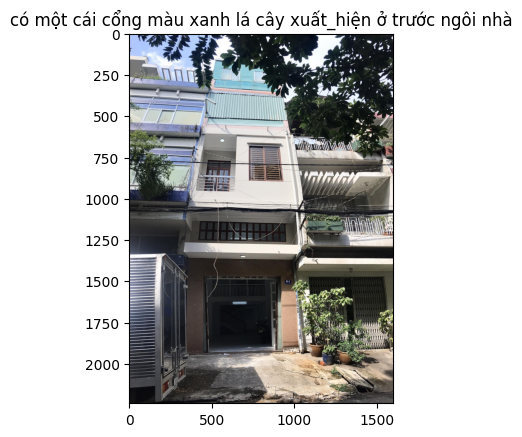

Early break in generate!


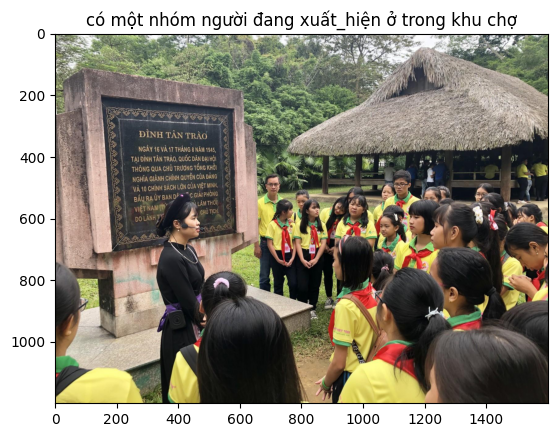

Early break in generate!


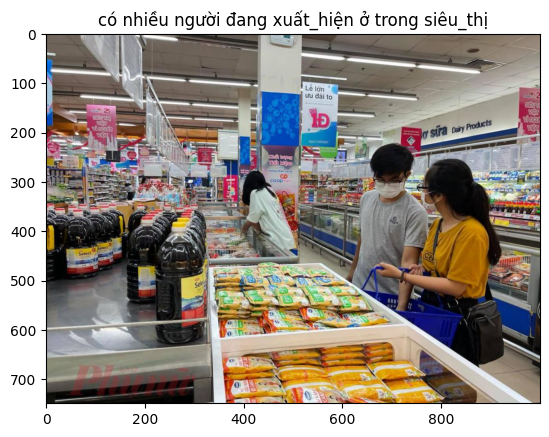

Early break in generate!


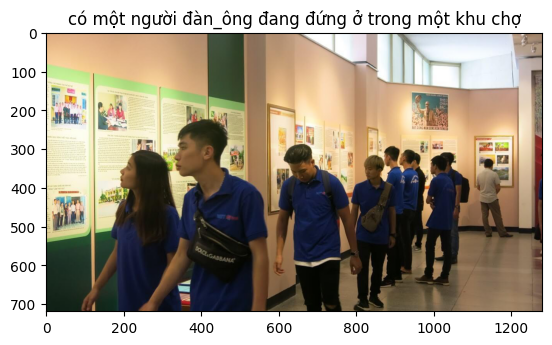

Early break in generate!


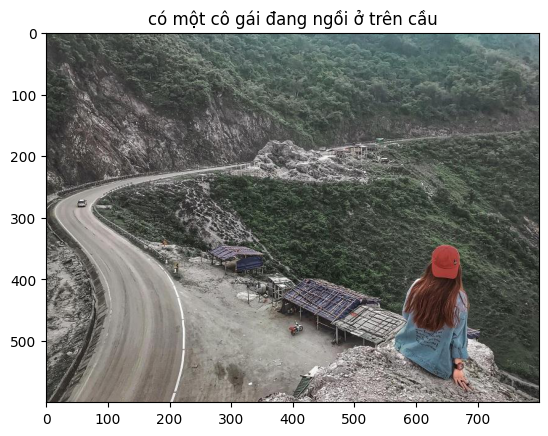

Early break in generate!


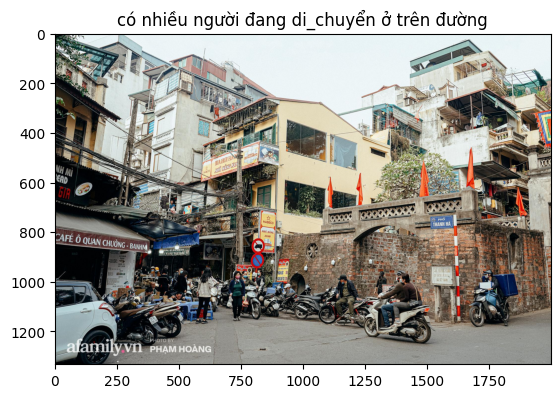

Early break in generate!


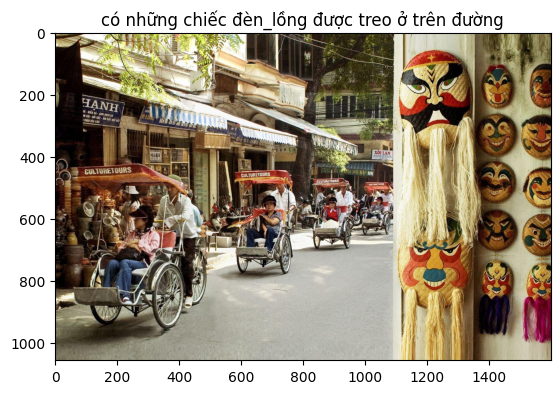

Early break in generate!


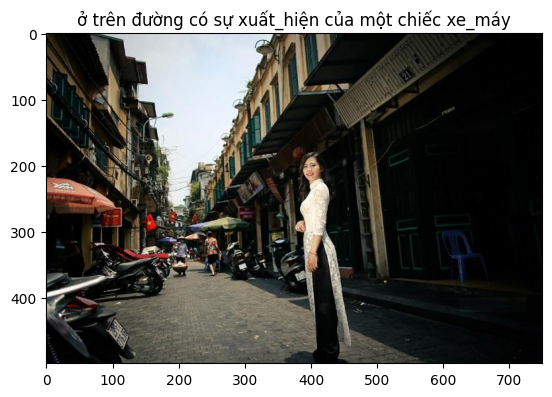

Early break in generate!


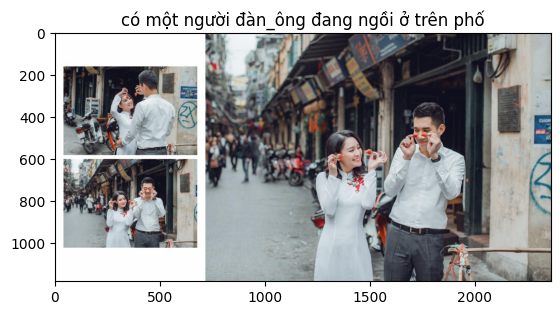

Early break in generate!


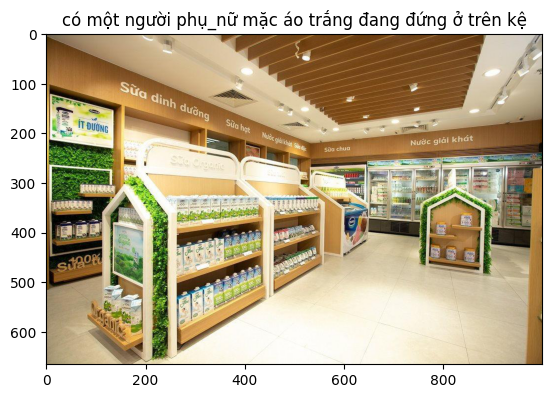

Early break in generate!


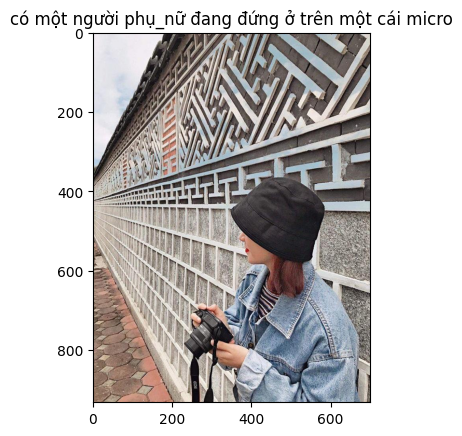

Early break in generate!


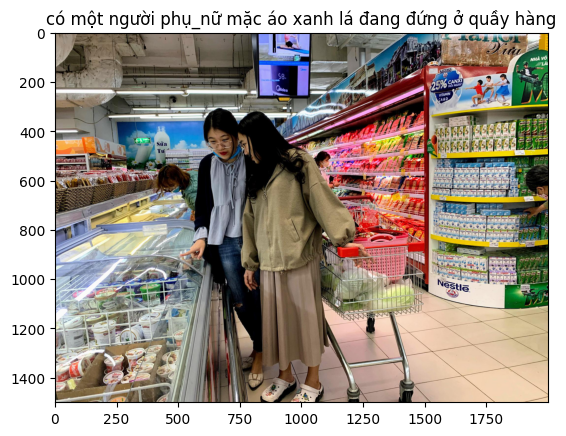

Early break in generate!


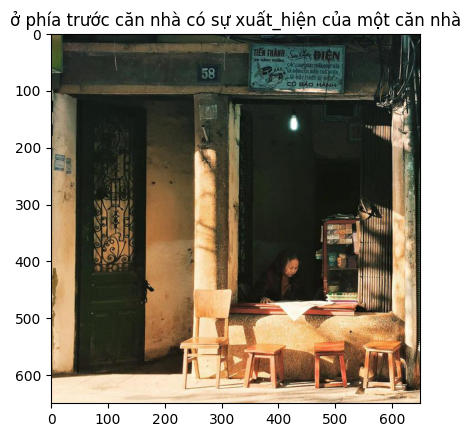

Early break in generate!


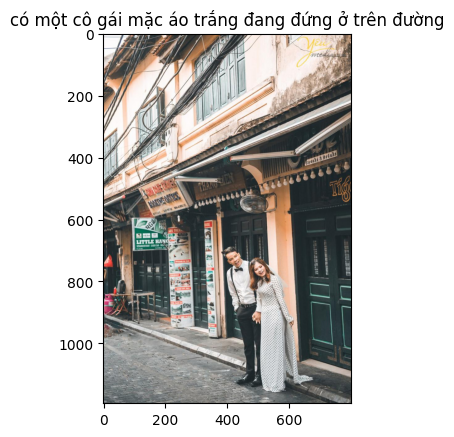

Early break in generate!


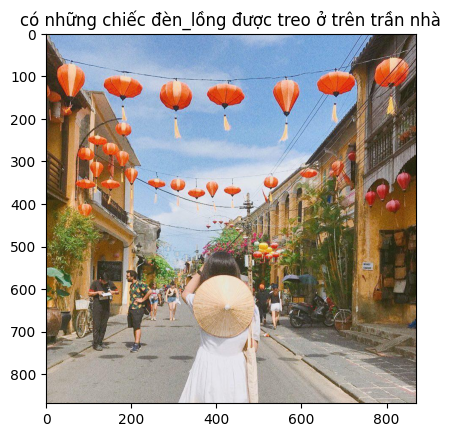

Early break in generate!


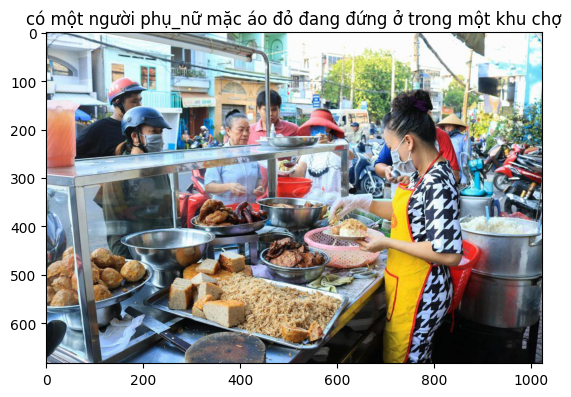

In [ ]:
image_captioning("public-test-images/00000000001.jpg")
image_captioning("public-test-images/00000000078.jpg")
image_captioning("public-test-images/00000000115.jpg")
image_captioning("public-test-images/00000000118.jpg")
image_captioning("public-test-images/00000000190.jpg")
image_captioning("public-test-images/00000000322.jpg")
image_captioning("public-test-images/00000000331.jpg")
image_captioning("public-test-images/00000000363.jpg")
image_captioning("public-test-images/00000000490.jpg")
image_captioning("public-test-images/00000000657.jpg")
image_captioning("public-test-images/00000000702.jpg")
image_captioning("public-test-images/00000000834.jpg")
image_captioning("public-test-images/00000001052.jpg")
image_captioning("public-test-images/00000001109.jpg")
image_captioning("public-test-images/00000009770.jpg")
image_captioning("public-test-images/00000011015.jpeg")

In [ ]:
# torch.save(decoder.state_dict(), 'res/my_model.pth')

In [ ]:
# for step, data in enumerate(train_dataloader):
#   images = data['images'].to(device)
#   out = model.generate(images)
#   print(out)
#   break